# RFECV multi-class prediction

In [1]:
import pathlib

import anndata
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix,
                             fbeta_score, make_scorer)
from sklearn.model_selection import StratifiedKFold

## Parameters

In [2]:
cluster_col = 'SubType'
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None

In [3]:
# Parameters
cluster_col = "SubType"
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None


In [4]:
output_dir = 'Model'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Marker Adata

In [5]:
adata = anndata.read_h5ad('Markers/cluster_markers.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 4347 × 30 
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice', 'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1', 'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1', 'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0', 'class_umap_1', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor'
    var: 'chrom', 'start', 'end'

## Cluster Order

In [7]:
if cluster_order_path is not None:
    cluster_order = pd.read_csv(cluster_order_path, header=None, index_col=0).index
else:
    cluster_order = sorted(adata.obs[cluster_col].unique())

## Supervise training

In [8]:
n_cell = adata.shape[0]
n_test = int(n_cell * test_portion)

In [9]:
# separate test and train
test_cells = adata.obs.sample(n_test, random_state=random_seed).index
test_judge = adata.obs_names.isin(test_cells)
train_judge = ~adata.obs_names.isin(test_cells)

In [10]:
test_df = pd.DataFrame(adata[test_judge, :].X,
                       index=adata.obs_names[test_judge],
                       columns=adata.var_names)
test_label = adata.obs.loc[test_judge, cluster_col]

train_df = pd.DataFrame(adata[train_judge, :].X,
                        index=adata.obs_names[train_judge],
                        columns=adata.var_names)
train_label = adata.obs.loc[train_judge, cluster_col]

## Training

In [11]:
estimator = BalancedRandomForestClassifier(n_estimators=n_estimators,
                                           criterion='gini',
                                           max_depth=None,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           min_weight_fraction_leaf=0.0,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           oob_score=False,
                                           sampling_strategy='auto',
                                           replacement=False,
                                           n_jobs=n_jobs,
                                           random_state=random_seed,
                                           verbose=3,
                                           warm_start=False,
                                           class_weight=None)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# TODO change to balanced accuracy score
scoring = make_scorer(balanced_accuracy_score)

clf = RFECV(estimator,
            step=3,
            min_features_to_select=1,
            cv=cv,
            scoring=scoring,
            verbose=3,
            n_jobs=10)

In [12]:
clf.fit(train_df, train_label)
joblib.dump(clf, 'Model/RFECV.lib')

Fitting estimator with 30 features.
building tree 1 of 100
building tree 2 of 100building tree 9 of 100

building tree 10 of 100
building tree 8 of 100
building tree 4 of 100
building tree 18 of 100building tree 3 of 100
building tree 5 of 100building tree 7 of 100


building tree 12 of 100building tree 6 of 100
building tree 13 of 100building tree 16 of 100


building tree 11 of 100
building tree 14 of 100
building tree 23 of 100
building tree 15 of 100
building tree 17 of 100
building tree 24 of 100
building tree 22 of 100
building tree 21 of 100
building tree 25 of 100
building tree 29 of 100
building tree 26 of 100
building tree 19 of 100
building tree 30 of 100
building tree 27 of 100
building tree 20 of 100
building tree 28 of 100
building tree 33 of 100
building tree 32 of 100
building tree 35 of 100
building tree 36 of 100building tree 34 of 100
building tree 41 of 100building tree 45 of 100building tree 40 of 100



building tree 37 of 100building tree 51 of 100building tree 3

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 56 of 100building tree 53 of 100

building tree 59 of 100
building tree 58 of 100
building tree 60 of 100
building tree 62 of 100building tree 61 of 100

building tree 63 of 100building tree 65 of 100
building tree 66 of 100

building tree 64 of 100
building tree 71 of 100
building tree 67 of 100
building tree 73 of 100
building tree 69 of 100
building tree 81 of 100building tree 76 of 100building tree 75 of 100
building tree 70 of 100


building tree 78 of 100building tree 72 of 100
building tree 68 of 100

building tree 79 of 100
building tree 74 of 100building tree 80 of 100

building tree 83 of 100
building tree 84 of 100
building tree 77 of 100
building tree 86 of 100
building tree 85 of 100building tree 90 of 100
building tree 82 of 100
building tree 87 of 100

building tree 89 of 100
building tree 88 of 100
building tree 93 of 100building tree 91 of 100

building tree 92 of 100
building tree 94 of 100
building tree 100 of 100building tree 96 of 100

building tree 9

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 2 of 100
building tree 4 of 100
building tree 1 of 100
building tree 5 of 100
building tree 6 of 100
building tree 3 of 100
building tree 9 of 100
building tree 10 of 100
building tree 19 of 100building tree 13 of 100

building tree 7 of 100
building tree 17 of 100
building tree 11 of 100
building tree 8 of 100
building tree 15 of 100
building tree 18 of 100
building tree 12 of 100
building tree 14 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 16 of 100
building tree 26 of 100
building tree 24 of 100
building tree 20 of 100
building tree 27 of 100
building tree 30 of 100building tree 28 of 100

building tree 29 of 100
building tree 25 of 100
building tree 31 of 100
building tree 32 of 100
building tree 35 of 100
building tree 34 of 100
building tree 33 of 100
building tree 40 of 100
building tree 38 of 100building tree 37 of 100

building tree 42 of 100
building tree 39 of 100
building tree 36 of 100
building tree 52 of 100bu

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 3 of 100
building tree 5 of 100
building tree 10 of 100
building tree 12 of 100
building tree 1 of 100
building tree 4 of 100
building tree 18 of 100building tree 11 of 100
building tree 2 of 100
building tree 13 of 100

building tree 16 of 100
building tree 14 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 23 of 100
building tree 17 of 100
building tree 21 of 100
building tree 19 of 100
building tree 24 of 100
building tree 27 of 100
building tree 22 of 100
building tree 20 of 100
building tree 6 of 100
building tree 26 of 100
building tree 25 of 100
building tree 15 of 100
building tree 30 of 100
building tree 29 of 100
building tree 28 of 100
building tree 31 of 100
building tree 32 of 100
building tree 39 of 100
building tree 36 of 100
building tree 34 of 100
building tree 35 of 100
building tree 33 of 100
building tree 38 of 100
building tree 37 of 100
building tree 46 of 100building tree 48 of 100building tree 41 of 100

bu

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


['Model/RFECV.lib']

## Featurs

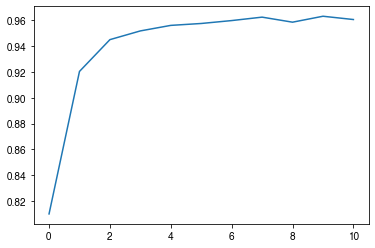

In [13]:
plt.plot(clf.grid_scores_)

In [14]:
feature_to_use = train_df.columns[clf.support_]
print(feature_to_use.size, 'features selected by RFECV')

27 features selected by RFECV


## Testing

In [15]:
# final pred
pred_label = clf.predict(test_df)

# final pred proba
pred_proba = clf.predict_proba(test_df)
pred_proba = pd.DataFrame(pred_proba, index=test_df.index, columns=clf.classes_)
pred_proba = pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished


In [16]:
balanced_accuracy_score(test_label, pred_label)

0.955108707896812

## Confusion matrix

In [17]:
cfm = confusion_matrix(test_label, pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 2)]

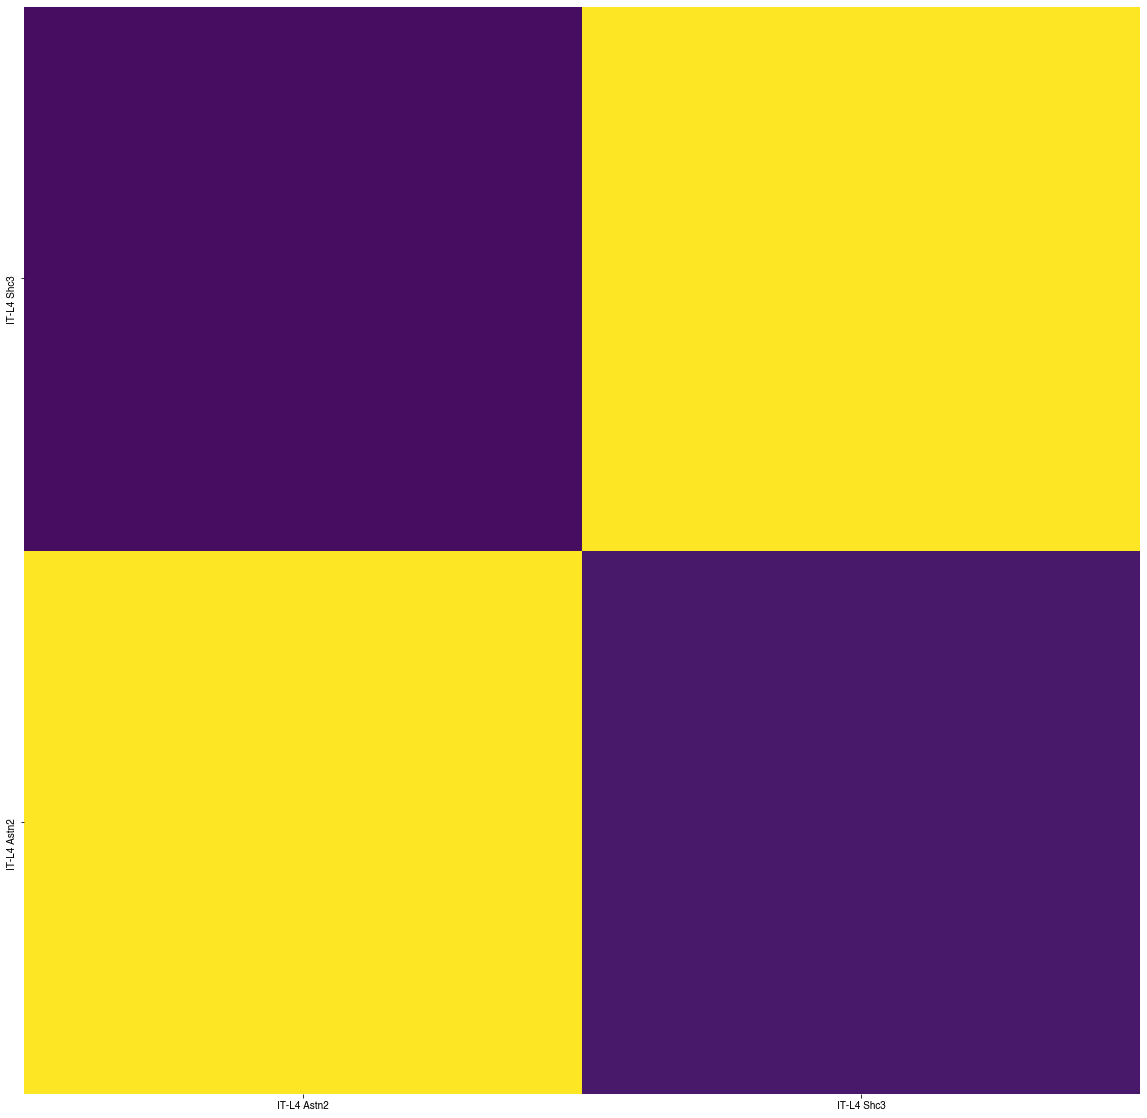

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [19]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = pred_proba.iloc[test_orders.argsort(), :]

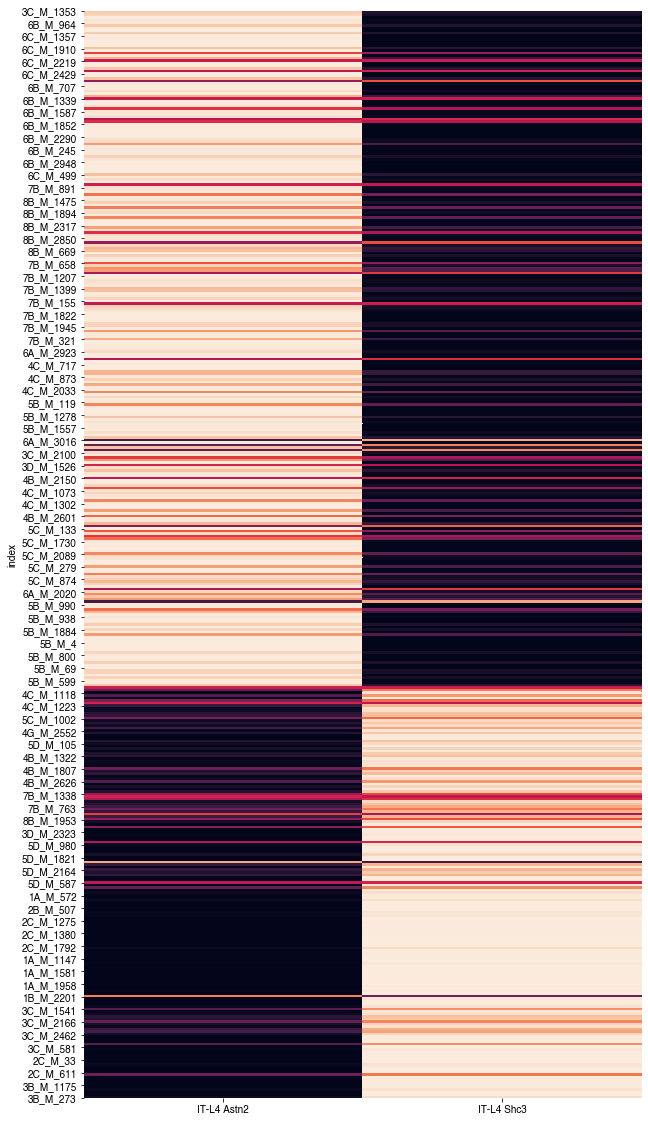

In [20]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

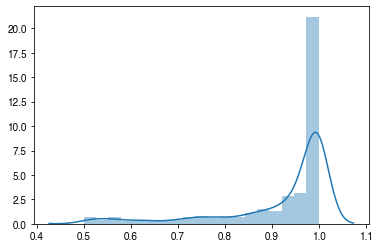

In [21]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

## Train final model with RFECV selected feature

In [22]:
selected_train_df = train_df.loc[:, feature_to_use]
selected_test_df = test_df.loc[:, feature_to_use]

In [23]:
# final estimator with larger trees
final_estimator = BalancedRandomForestClassifier(n_estimators=n_estimators_final,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 min_samples_split=2,
                                                 min_samples_leaf=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 bootstrap=True,
                                                 oob_score=False,
                                                 sampling_strategy='auto',
                                                 replacement=False,
                                                 n_jobs=n_jobs,
                                                 random_state=random_seed,
                                                 verbose=3,
                                                 warm_start=False,
                                                 class_weight=None)

In [24]:
final_estimator.fit(selected_train_df, train_label)
joblib.dump(final_estimator, 'Model/FinalClassifier.lib')

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 2 of 500
building tree 1 of 500
building tree 5 of 500
building tree 13 of 500
building tree 3 of 500
building tree 4 of 500
building tree 7 of 500
building tree 8 of 500
building tree 10 of 500
building tree 15 of 500
building tree 14 of 500
building tree 6 of 500
building tree 9 of 500
building tree 18 of 500
building tree 16 of 500
building tree 12 of 500
building tree 11 of 500
building tree 26 of 500
building tree 22 of 500
building tree 17 of 500
building tree 20 of 500
building tree 19 of 500
building tree 24 of 500
building tree 25 of 500
building tree 27 of 500
building tree 30 of 500
building tree 23 of 500
building tree 21 of 500
building tree 29 of 500
building tree 28 of 500
building tree 31 of 500
building tree 32 of 500
building tree 34 of 500
building tree 35 of 500
building tree 37 of 500
building tree 42 of 500
building tree 36 of 500
building tree 38 of 500
building tree 33 of 500building tree 48 of 500building tree 45 of 500


building tree 40 of 500bu

[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.3s


building tree 137 of 500building tree 130 of 500building tree 142 of 500
building tree 136 of 500building tree 140 of 500




building tree 134 of 500building tree 133 of 500

building tree 139 of 500building tree 135 of 500

building tree 143 of 500building tree 145 of 500

building tree 141 of 500building tree 138 of 500building tree 146 of 500building tree 144 of 500



building tree 148 of 500
building tree 150 of 500building tree 151 of 500

building tree 152 of 500building tree 147 of 500building tree 149 of 500


building tree 153 of 500
building tree 154 of 500
building tree 156 of 500
building tree 155 of 500
building tree 158 of 500
building tree 157 of 500
building tree 159 of 500
building tree 163 of 500building tree 161 of 500

building tree 166 of 500building tree 162 of 500
building tree 170 of 500building tree 164 of 500


building tree 160 of 500
building tree 167 of 500
building tree 169 of 500building tree 172 of 500

building tree 175 of 500building tree 168 of 500


[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.8s


building tree 271 of 500
building tree 273 of 500
building tree 278 of 500
building tree 274 of 500building tree 272 of 500

building tree 280 of 500
building tree 282 of 500
building tree 276 of 500
building tree 281 of 500
building tree 279 of 500
building tree 283 of 500
building tree 286 of 500
building tree 285 of 500
building tree 284 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 287 of 500
building tree 292 of 500
building tree 297 of 500building tree 300 of 500

building tree 294 of 500
building tree 293 of 500building tree 299 of 500

building tree 298 of 500building tree 296 of 500

building tree 295 of 500
building tree 301 of 500
building tree 303 of 500building tree 302 of 500building tree 308 of 500
building tree 306 of 500
building tree 307 of 500
building tree 305 of 500


building tree 304 of 500
building tree 309 of 500
building tree 312 of 500
building tree 314 of 500
building tree 310 of 500b

[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    1.5s finished


['Model/FinalClassifier.lib']

## Final Pred

In [25]:
final_pred_label = final_estimator.predict(selected_test_df)

final_pred_proba = final_estimator.predict_proba(selected_test_df)
final_pred_proba = pd.DataFrame(final_pred_proba, index=test_df.index, columns=clf.classes_)
final_pred_proba = final_pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.1s finished


In [26]:
balanced_accuracy_score(test_label, final_pred_label)

0.9606849160752506

## Final evaluate

In [27]:
cfm = confusion_matrix(test_label, final_pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 2)]

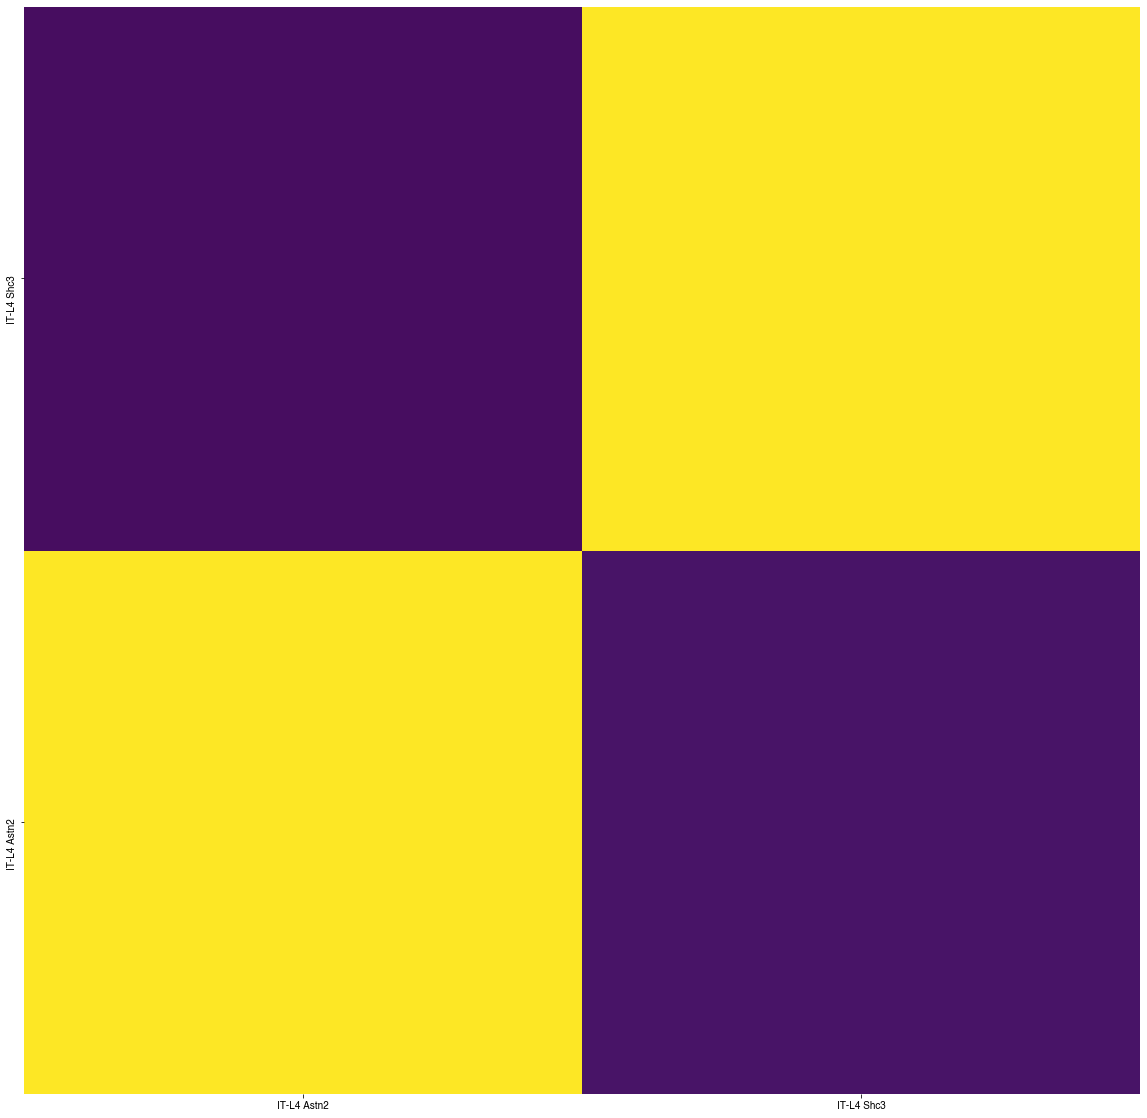

In [28]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [29]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = final_pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = final_pred_proba.iloc[test_orders.argsort(), :]

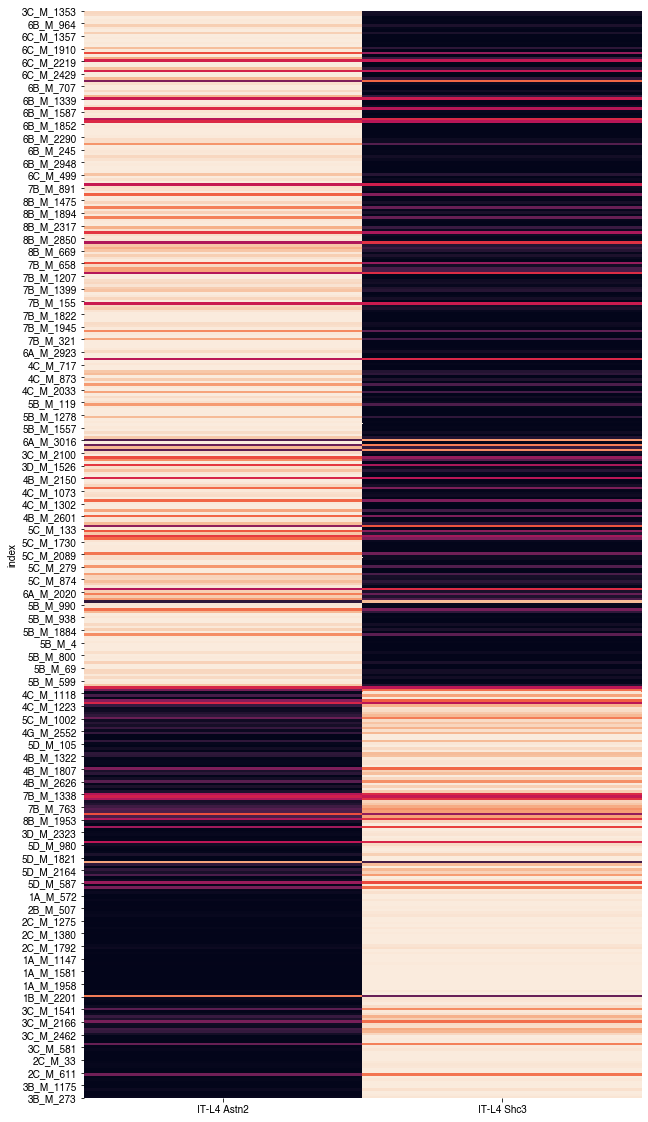

In [30]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

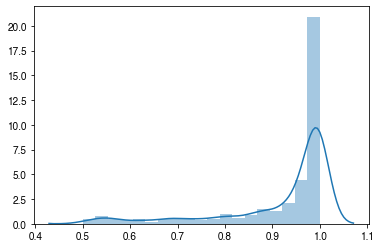

In [31]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

In [32]:
with open('finish_flag', 'w') as f:
    f.write('Oh yeah')